In [1]:
# Imports 
import findspark
findspark.add_packages('mysql:mysql-connector-java:8.0.11')
from pyspark.sql import SparkSession
from pyspark.sql.functions import*
from pyspark.sql.types import*

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import requests
import seaborn as sns
import warnings
warnings.filterwarnings("ignore") 


## Loading Data and creating Spark DataFrames

In [2]:
spark = SparkSession.builder.master("local[*]").appName("Credit_Cards").getOrCreate()

:: loading settings :: url = jar:file:/Users/purple/opt/anaconda3/envs/ps_capstone/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/purple/.ivy2/cache
The jars for the packages stored in: /Users/purple/.ivy2/jars
mysql#mysql-connector-java added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-5a6555fc-da5e-465d-87d2-3dda52601ec6;1.0
	confs: [default]
	found mysql#mysql-connector-java;8.0.11 in central
	found com.google.protobuf#protobuf-java;2.6.0 in central
:: resolution report :: resolve 167ms :: artifacts dl 7ms
	:: modules in use:
	com.google.protobuf#protobuf-java;2.6.0 from central in [default]
	mysql#mysql-connector-java;8.0.11 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	----------------------------------------

In [3]:
df_branch = spark.read.json('data/cdw_sapp_branch.json')  
df_credit = spark.read.json('data/cdw_sapp_credit.json') 
df_customers = spark.read.json('data/cdw_sapp_custmer.json')

In [4]:
type(df_branch)

pyspark.sql.dataframe.DataFrame

# Cleaning DataFrames


### Cleaning the branch df

In [5]:
df_branch.show(5)

+-----------------+-----------+------------+------------+------------+-----------------+----------+--------------------+
|      BRANCH_CITY|BRANCH_CODE| BRANCH_NAME|BRANCH_PHONE|BRANCH_STATE|    BRANCH_STREET|BRANCH_ZIP|        LAST_UPDATED|
+-----------------+-----------+------------+------------+------------+-----------------+----------+--------------------+
|        Lakeville|          1|Example Bank|  1234565276|          MN|     Bridle Court|     55044|2018-04-18T16:51:...|
|          Huntley|          2|Example Bank|  1234618993|          IL|Washington Street|     60142|2018-04-18T16:51:...|
|SouthRichmondHill|          3|Example Bank|  1234985926|          NY|    Warren Street|     11419|2018-04-18T16:51:...|
|       Middleburg|          4|Example Bank|  1234663064|          FL| Cleveland Street|     32068|2018-04-18T16:51:...|
|    KingOfPrussia|          5|Example Bank|  1234849701|          PA|      14th Street|     19406|2018-04-18T16:51:...|
+-----------------+-----------+-

In [6]:
df_branch.columns

['BRANCH_CITY',
 'BRANCH_CODE',
 'BRANCH_NAME',
 'BRANCH_PHONE',
 'BRANCH_STATE',
 'BRANCH_STREET',
 'BRANCH_ZIP',
 'LAST_UPDATED']

In [7]:
df_branch.select('BRANCH_PHONE').show(5)

+------------+
|BRANCH_PHONE|
+------------+
|  1234565276|
|  1234618993|
|  1234985926|
|  1234663064|
|  1234849701|
+------------+
only showing top 5 rows



In [8]:
#transforming the branch df
df_branch = df_branch.withColumn('BRANCH_PHONE', concat(lit('('), col('BRANCH_PHONE')[0:3], lit(')'), 
                                col('BRANCH_PHONE')[4:3], lit('-'), col('BRANCH_PHONE')[7:9]))

df_branch.select('BRANCH_PHONE').show(5)

+-------------+
| BRANCH_PHONE|
+-------------+
|(123)456-5276|
|(123)461-8993|
|(123)498-5926|
|(123)466-3064|
|(123)484-9701|
+-------------+
only showing top 5 rows



In [9]:
#checking for nulls in zip code
df_branch.filter(df_branch.BRANCH_ZIP.isNull()).show()

+-----------+-----------+-----------+------------+------------+-------------+----------+------------+
|BRANCH_CITY|BRANCH_CODE|BRANCH_NAME|BRANCH_PHONE|BRANCH_STATE|BRANCH_STREET|BRANCH_ZIP|LAST_UPDATED|
+-----------+-----------+-----------+------------+------------+-------------+----------+------------+
+-----------+-----------+-----------+------------+------------+-------------+----------+------------+



In [10]:
#there are no nulls in branch zip
print(df_branch.count())
print(df_branch.filter(col('BRANCH_ZIP').isNull()).count())
print(df_branch.filter(col('BRANCH_ZIP').isNotNull()).count())

115
0
115


In [11]:
df_branch.na.fill(value=99999,subset=['BRANCH_ZIP'])


DataFrame[BRANCH_CITY: string, BRANCH_CODE: bigint, BRANCH_NAME: string, BRANCH_PHONE: string, BRANCH_STATE: string, BRANCH_STREET: string, BRANCH_ZIP: bigint, LAST_UPDATED: string]

### Cleaning the credit df

In [12]:
df_credit.show(5)

+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+
|BRANCH_CODE|  CREDIT_CARD_NO| CUST_SSN|DAY|MONTH|TRANSACTION_ID|TRANSACTION_TYPE|TRANSACTION_VALUE|YEAR|
+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+
|        114|4210653349028689|123459988| 14|    2|             1|       Education|             78.9|2018|
|         35|4210653349028689|123459988| 20|    3|             2|   Entertainment|            14.24|2018|
|        160|4210653349028689|123459988|  8|    7|             3|         Grocery|             56.7|2018|
|        114|4210653349028689|123459988| 19|    4|             4|   Entertainment|            59.73|2018|
|         93|4210653349028689|123459988| 10|   10|             5|             Gas|             3.59|2018|
+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+
only showing top 5 rows



In [13]:
df_credit.columns

['BRANCH_CODE',
 'CREDIT_CARD_NO',
 'CUST_SSN',
 'DAY',
 'MONTH',
 'TRANSACTION_ID',
 'TRANSACTION_TYPE',
 'TRANSACTION_VALUE',
 'YEAR']

In [14]:
df_credit = df_credit.withColumnRenamed('CREDIT_CARD_NO', 'CUST_CC_NO')
df_credit = df_credit.withColumn('TIMEID', expr('make_date(YEAR, MONTH, DAY)'))
df_credit.show(5)

+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+----------+
|BRANCH_CODE|      CUST_CC_NO| CUST_SSN|DAY|MONTH|TRANSACTION_ID|TRANSACTION_TYPE|TRANSACTION_VALUE|YEAR|    TIMEID|
+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+----------+
|        114|4210653349028689|123459988| 14|    2|             1|       Education|             78.9|2018|2018-02-14|
|         35|4210653349028689|123459988| 20|    3|             2|   Entertainment|            14.24|2018|2018-03-20|
|        160|4210653349028689|123459988|  8|    7|             3|         Grocery|             56.7|2018|2018-07-08|
|        114|4210653349028689|123459988| 19|    4|             4|   Entertainment|            59.73|2018|2018-04-19|
|         93|4210653349028689|123459988| 10|   10|             5|             Gas|             3.59|2018|2018-10-10|
+-----------+----------------+---------+---+-----+--------------

### Cleaning the customers df

In [15]:
df_customers.select('CUST_PHONE').show(5)

+----------+
|CUST_PHONE|
+----------+
|   1237818|
|   1238933|
|   1243018|
|   1243215|
|   1242074|
+----------+
only showing top 5 rows



In [16]:
df_customers = df_customers.withColumn('CUST_PHONE', concat(lit('(617)'), col('CUST_PHONE')[1:3], 
                                        lit('-'), col('CUST_PHONE')[4:8] ))
df_customers.select('CUST_PHONE').show(5)

+-------------+
|   CUST_PHONE|
+-------------+
|(617)123-7818|
|(617)123-8933|
|(617)124-3018|
|(617)124-3215|
|(617)124-2074|
+-------------+
only showing top 5 rows



In [17]:
df_customers.columns

['APT_NO',
 'CREDIT_CARD_NO',
 'CUST_CITY',
 'CUST_COUNTRY',
 'CUST_EMAIL',
 'CUST_PHONE',
 'CUST_STATE',
 'CUST_ZIP',
 'FIRST_NAME',
 'LAST_NAME',
 'LAST_UPDATED',
 'MIDDLE_NAME',
 'SSN',
 'STREET_NAME']

In [18]:
#transforming the customer df
df_customers = df_customers.withColumn('FIRST_NAME', initcap(df_customers['FIRST_NAME']))
df_customers = df_customers.withColumn('MIDDLE_NAME', lower(df_customers['MIDDLE_NAME']))
df_customers = df_customers.withColumn('LAST_NAME', initcap(df_customers['LAST_NAME']))
df_customers = df_customers.withColumnRenamed('CREDIT_CARD_NO', 'Credit_card_no')
df_customers = df_customers.withColumn('FULL_STREET_ADDRESS', concat(col('APT_NO'),lit(','),col('STREET_NAME')))
df_customers.show(5)


+------+----------------+------------+-------------+-------------------+-------------+----------+--------+----------+---------+--------------------+-----------+---------+-----------------+--------------------+
|APT_NO|  Credit_card_no|   CUST_CITY| CUST_COUNTRY|         CUST_EMAIL|   CUST_PHONE|CUST_STATE|CUST_ZIP|FIRST_NAME|LAST_NAME|        LAST_UPDATED|MIDDLE_NAME|      SSN|      STREET_NAME| FULL_STREET_ADDRESS|
+------+----------------+------------+-------------+-------------------+-------------+----------+--------+----------+---------+--------------------+-----------+---------+-----------------+--------------------+
|   656|4210653310061055|     Natchez|United States|AHooper@example.com|(617)123-7818|        MS|   39120|      Alec|   Hooper|2018-04-21T12:49:...|         wm|123456100|Main Street North|656,Main Street N...|
|   829|4210653310102868|Wethersfield|United States|EHolman@example.com|(617)123-8933|        CT|   06109|      Etta|   Holman|2018-04-21T12:49:...|    brendan|

In [19]:
#dropping address and apt cols
df_customers = df_customers.drop('APT_NO', 'STREET_NAME')
df_customers.columns

['Credit_card_no',
 'CUST_CITY',
 'CUST_COUNTRY',
 'CUST_EMAIL',
 'CUST_PHONE',
 'CUST_STATE',
 'CUST_ZIP',
 'FIRST_NAME',
 'LAST_NAME',
 'LAST_UPDATED',
 'MIDDLE_NAME',
 'SSN',
 'FULL_STREET_ADDRESS']

In [20]:
print(df_branch.show(5))
print(df_credit.show(5))
print(df_customers.show(5))

+-----------------+-----------+------------+-------------+------------+-----------------+----------+--------------------+
|      BRANCH_CITY|BRANCH_CODE| BRANCH_NAME| BRANCH_PHONE|BRANCH_STATE|    BRANCH_STREET|BRANCH_ZIP|        LAST_UPDATED|
+-----------------+-----------+------------+-------------+------------+-----------------+----------+--------------------+
|        Lakeville|          1|Example Bank|(123)456-5276|          MN|     Bridle Court|     55044|2018-04-18T16:51:...|
|          Huntley|          2|Example Bank|(123)461-8993|          IL|Washington Street|     60142|2018-04-18T16:51:...|
|SouthRichmondHill|          3|Example Bank|(123)498-5926|          NY|    Warren Street|     11419|2018-04-18T16:51:...|
|       Middleburg|          4|Example Bank|(123)466-3064|          FL| Cleveland Street|     32068|2018-04-18T16:51:...|
|    KingOfPrussia|          5|Example Bank|(123)484-9701|          PA|      14th Street|     19406|2018-04-18T16:51:...|
+-----------------+-----

In [21]:
df_branch.printSchema()


root
 |-- BRANCH_CITY: string (nullable = true)
 |-- BRANCH_CODE: long (nullable = true)
 |-- BRANCH_NAME: string (nullable = true)
 |-- BRANCH_PHONE: string (nullable = true)
 |-- BRANCH_STATE: string (nullable = true)
 |-- BRANCH_STREET: string (nullable = true)
 |-- BRANCH_ZIP: long (nullable = true)
 |-- LAST_UPDATED: string (nullable = true)



In [22]:
df_credit.printSchema()


root
 |-- BRANCH_CODE: long (nullable = true)
 |-- CUST_CC_NO: string (nullable = true)
 |-- CUST_SSN: long (nullable = true)
 |-- DAY: long (nullable = true)
 |-- MONTH: long (nullable = true)
 |-- TRANSACTION_ID: long (nullable = true)
 |-- TRANSACTION_TYPE: string (nullable = true)
 |-- TRANSACTION_VALUE: double (nullable = true)
 |-- YEAR: long (nullable = true)
 |-- TIMEID: date (nullable = true)



In [23]:
df_customers.printSchema()

root
 |-- Credit_card_no: string (nullable = true)
 |-- CUST_CITY: string (nullable = true)
 |-- CUST_COUNTRY: string (nullable = true)
 |-- CUST_EMAIL: string (nullable = true)
 |-- CUST_PHONE: string (nullable = true)
 |-- CUST_STATE: string (nullable = true)
 |-- CUST_ZIP: string (nullable = true)
 |-- FIRST_NAME: string (nullable = true)
 |-- LAST_NAME: string (nullable = true)
 |-- LAST_UPDATED: string (nullable = true)
 |-- MIDDLE_NAME: string (nullable = true)
 |-- SSN: long (nullable = true)
 |-- FULL_STREET_ADDRESS: string (nullable = true)



In [24]:
df_branch.write.format("jdbc") \
  .mode("overwrite") \
  .option("driver", "com.mysql.cj.jdbc.Driver")\
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
  .option("dbtable", "creditcard_capstone.CDW_SAPP_BRANCH") \
  .option("user", "root") \
  .option("password", "pass1234") \
  .save()

Wed Mar 01 23:03:50 EST 2023 WARN: Establishing SSL connection without server's identity verification is not recommended. According to MySQL 5.5.45+, 5.6.26+ and 5.7.6+ requirements SSL connection must be established by default if explicit option isn't set. For compliance with existing applications not using SSL the verifyServerCertificate property is set to 'false'. You need either to explicitly disable SSL by setting useSSL=false, or set useSSL=true and provide truststore for server certificate verification.
Wed Mar 01 23:03:51 EST 2023 WARN: Establishing SSL connection without server's identity verification is not recommended. According to MySQL 5.5.45+, 5.6.26+ and 5.7.6+ requirements SSL connection must be established by default if explicit option isn't set. For compliance with existing applications not using SSL the verifyServerCertificate property is set to 'false'. You need either to explicitly disable SSL by setting useSSL=false, or set useSSL=true and provide truststore for s

In [25]:
df_credit.write.format("jdbc") \
  .mode("overwrite") \
  .option("driver", "com.mysql.cj.jdbc.Driver")\
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
  .option("dbtable", "creditcard_capstone.CDW_SAPP_CREDIT_CARD") \
  .option("user", "root") \
  .option("password", "pass1234") \
  .save()

Wed Mar 01 23:03:51 EST 2023 WARN: Establishing SSL connection without server's identity verification is not recommended. According to MySQL 5.5.45+, 5.6.26+ and 5.7.6+ requirements SSL connection must be established by default if explicit option isn't set. For compliance with existing applications not using SSL the verifyServerCertificate property is set to 'false'. You need either to explicitly disable SSL by setting useSSL=false, or set useSSL=true and provide truststore for server certificate verification.
Wed Mar 01 23:03:52 EST 2023 WARN: Establishing SSL connection without server's identity verification is not recommended. According to MySQL 5.5.45+, 5.6.26+ and 5.7.6+ requirements SSL connection must be established by default if explicit option isn't set. For compliance with existing applications not using SSL the verifyServerCertificate property is set to 'false'. You need either to explicitly disable SSL by setting useSSL=false, or set useSSL=true and provide truststore for s

In [26]:
df_customers.write.format("jdbc") \
  .mode("overwrite") \
  .option("driver", "com.mysql.cj.jdbc.Driver")\
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
  .option("dbtable", "creditcard_capstone.CDW_SAPP_CUSTOMER") \
  .option("user", "root") \
  .option("password", "pass1234") \
  .save()

Wed Mar 01 23:03:55 EST 2023 WARN: Establishing SSL connection without server's identity verification is not recommended. According to MySQL 5.5.45+, 5.6.26+ and 5.7.6+ requirements SSL connection must be established by default if explicit option isn't set. For compliance with existing applications not using SSL the verifyServerCertificate property is set to 'false'. You need either to explicitly disable SSL by setting useSSL=false, or set useSSL=true and provide truststore for server certificate verification.
Wed Mar 01 23:03:55 EST 2023 WARN: Establishing SSL connection without server's identity verification is not recommended. According to MySQL 5.5.45+, 5.6.26+ and 5.7.6+ requirements SSL connection must be established by default if explicit option isn't set. For compliance with existing applications not using SSL the verifyServerCertificate property is set to 'false'. You need either to explicitly disable SSL by setting useSSL=false, or set useSSL=true and provide truststore for s

# Data Wrangling

In [27]:
df_branch.show(5)
df_credit.show(5)
df_customers.show(5)

+-----------------+-----------+------------+-------------+------------+-----------------+----------+--------------------+
|      BRANCH_CITY|BRANCH_CODE| BRANCH_NAME| BRANCH_PHONE|BRANCH_STATE|    BRANCH_STREET|BRANCH_ZIP|        LAST_UPDATED|
+-----------------+-----------+------------+-------------+------------+-----------------+----------+--------------------+
|        Lakeville|          1|Example Bank|(123)456-5276|          MN|     Bridle Court|     55044|2018-04-18T16:51:...|
|          Huntley|          2|Example Bank|(123)461-8993|          IL|Washington Street|     60142|2018-04-18T16:51:...|
|SouthRichmondHill|          3|Example Bank|(123)498-5926|          NY|    Warren Street|     11419|2018-04-18T16:51:...|
|       Middleburg|          4|Example Bank|(123)466-3064|          FL| Cleveland Street|     32068|2018-04-18T16:51:...|
|    KingOfPrussia|          5|Example Bank|(123)484-9701|          PA|      14th Street|     19406|2018-04-18T16:51:...|
+-----------------+-----

In [28]:
df_cust_and_credit = df_credit.join(df_customers, df_credit.CUST_SSN == df_customers.SSN,"outer")
df_cust_and_credit.printSchema()

root
 |-- BRANCH_CODE: long (nullable = true)
 |-- CUST_CC_NO: string (nullable = true)
 |-- CUST_SSN: long (nullable = true)
 |-- DAY: long (nullable = true)
 |-- MONTH: long (nullable = true)
 |-- TRANSACTION_ID: long (nullable = true)
 |-- TRANSACTION_TYPE: string (nullable = true)
 |-- TRANSACTION_VALUE: double (nullable = true)
 |-- YEAR: long (nullable = true)
 |-- TIMEID: date (nullable = true)
 |-- Credit_card_no: string (nullable = true)
 |-- CUST_CITY: string (nullable = true)
 |-- CUST_COUNTRY: string (nullable = true)
 |-- CUST_EMAIL: string (nullable = true)
 |-- CUST_PHONE: string (nullable = true)
 |-- CUST_STATE: string (nullable = true)
 |-- CUST_ZIP: string (nullable = true)
 |-- FIRST_NAME: string (nullable = true)
 |-- LAST_NAME: string (nullable = true)
 |-- LAST_UPDATED: string (nullable = true)
 |-- MIDDLE_NAME: string (nullable = true)
 |-- SSN: long (nullable = true)
 |-- FULL_STREET_ADDRESS: string (nullable = true)



In [29]:
#changing BRANCH_CODE name - to avoid ambigous column error when querying
df_branch = df_branch.withColumnRenamed('BRANCH_CODE','BRANCHCODE') 
df_branch_and_credit = df_credit.join(df_branch, df_credit.BRANCH_CODE == df_branch.BRANCHCODE, "outer")
df_branch_and_credit.printSchema()

root
 |-- BRANCH_CODE: long (nullable = true)
 |-- CUST_CC_NO: string (nullable = true)
 |-- CUST_SSN: long (nullable = true)
 |-- DAY: long (nullable = true)
 |-- MONTH: long (nullable = true)
 |-- TRANSACTION_ID: long (nullable = true)
 |-- TRANSACTION_TYPE: string (nullable = true)
 |-- TRANSACTION_VALUE: double (nullable = true)
 |-- YEAR: long (nullable = true)
 |-- TIMEID: date (nullable = true)
 |-- BRANCH_CITY: string (nullable = true)
 |-- BRANCHCODE: long (nullable = true)
 |-- BRANCH_NAME: string (nullable = true)
 |-- BRANCH_PHONE: string (nullable = true)
 |-- BRANCH_STATE: string (nullable = true)
 |-- BRANCH_STREET: string (nullable = true)
 |-- BRANCH_ZIP: long (nullable = true)
 |-- LAST_UPDATED: string (nullable = true)



In [30]:
#dropped cols to be able to check for nulls
df_cust_and_credit = df_cust_and_credit.drop('TIMEID')
df_cust_and_credit = df_cust_and_credit.drop('LAST_UPDATED')
df_branch_and_credit = df_branch_and_credit.drop('BRANCHCODE')

In [31]:
#checking for nulls
df_cust_and_credit.select([count(when(isnan(c), c)).alias(c) for c in df_cust_and_credit.columns]).show()

+-----------+----------+--------+---+-----+--------------+----------------+-----------------+----+--------------+---------+------------+----------+----------+----------+--------+----------+---------+-----------+---+-------------------+
|BRANCH_CODE|CUST_CC_NO|CUST_SSN|DAY|MONTH|TRANSACTION_ID|TRANSACTION_TYPE|TRANSACTION_VALUE|YEAR|Credit_card_no|CUST_CITY|CUST_COUNTRY|CUST_EMAIL|CUST_PHONE|CUST_STATE|CUST_ZIP|FIRST_NAME|LAST_NAME|MIDDLE_NAME|SSN|FULL_STREET_ADDRESS|
+-----------+----------+--------+---+-----+--------------+----------------+-----------------+----+--------------+---------+------------+----------+----------+----------+--------+----------+---------+-----------+---+-------------------+
|          0|         0|       0|  0|    0|             0|               0|                0|   0|             0|        0|           0|         0|         0|         0|       0|         0|        0|          0|  0|                  0|
+-----------+----------+--------+---+-----+-------------

In [32]:
df_cust_and_credit.select([count(when(col(c).isNull(), c)).alias(c) for c in df_cust_and_credit.columns]).show()

+-----------+----------+--------+---+-----+--------------+----------------+-----------------+----+--------------+---------+------------+----------+----------+----------+--------+----------+---------+-----------+---+-------------------+
|BRANCH_CODE|CUST_CC_NO|CUST_SSN|DAY|MONTH|TRANSACTION_ID|TRANSACTION_TYPE|TRANSACTION_VALUE|YEAR|Credit_card_no|CUST_CITY|CUST_COUNTRY|CUST_EMAIL|CUST_PHONE|CUST_STATE|CUST_ZIP|FIRST_NAME|LAST_NAME|MIDDLE_NAME|SSN|FULL_STREET_ADDRESS|
+-----------+----------+--------+---+-----+--------------+----------------+-----------------+----+--------------+---------+------------+----------+----------+----------+--------+----------+---------+-----------+---+-------------------+
|          0|         0|       0|  0|    0|             0|               0|                0|   0|             0|        0|           0|         0|         0|         0|       0|         0|        0|          0|  0|                  0|
+-----------+----------+--------+---+-----+-------------

In [33]:
pd_branch = df_branch.toPandas()
pd_credit = df_credit.toPandas()
pd_customers = df_customers.toPandas()

In [34]:
pd_credit = pd_credit.rename(columns = {'CUST_SSN':'SSN'})
pd_customer_credit = pd.merge(pd_credit, pd_customers, on ='SSN')

In [35]:
pd_customer_credit['YEAR'].value_counts()

2018    46694
Name: YEAR, dtype: int64

In [36]:
pd_customer_credit = pd_customer_credit.drop(['CUST_CC_NO','CUST_EMAIL','TIMEID','TRANSACTION_ID',
                'Credit_card_no', 'CUST_PHONE', 'LAST_UPDATED', 'CUST_CITY','CUST_COUNTRY'], axis=1)
pd_trans_type = pd_customer_credit.groupby(['TRANSACTION_TYPE'])['TRANSACTION_VALUE'].sum()
pd_trans_type

TRANSACTION_TYPE
Bills            351405.28
Education        337980.07
Entertainment    338950.10
Gas              336059.26
Grocery          337051.63
Healthcare       340476.20
Test             341310.37
Name: TRANSACTION_VALUE, dtype: float64

In [37]:
#https://towardsdatascience.com/bring-your-jupyter-notebook-to-life-with-interactive-widgets-bc12e03f0916
ALL = 'ALL'
def unique_sorted_values_plus_ALL(array):
    unique = array.unique().tolist()
    unique.sort()
    unique.insert(0, ALL)
    return unique

In [38]:
output = widgets.Output()

dropdown_zipcode = widgets.Dropdown(options = unique_sorted_values_plus_ALL(pd_customer_credit.CUST_ZIP))
dropdown_month = widgets.Dropdown(options = unique_sorted_values_plus_ALL(pd_customer_credit.MONTH))

def common_filtering(month, zipcode):
    output.clear_output()
    
    if (month == ALL) & (zipcode == ALL):
        common_filter = pd_customer_credit
    elif (month == ALL):
        common_filter = pd_customer_credit[pd_customer_credit.CUST_ZIP == zipcode]
    elif (zipcode == ALL):
        common_filter = pd_customer_credit[pd_customer_credit.MONTH == month]
    else:
        common_filter = pd_customer_credit[(pd_customer_credit.MONTH == month) & 
                                  (pd_customer_credit.CUST_ZIP == zipcode)]
    
    with output:
        display(common_filter)
        
        
def dropdown_month_eventhandler(change):
    common_filtering(change.new, dropdown_zipcode.value)
    
def dropdown_zipcode_eventhandler(change):
    common_filtering(dropdown_month.value, change.new)

dropdown_month.observe(dropdown_month_eventhandler, names='value')
dropdown_zipcode.observe(dropdown_zipcode_eventhandler, names='value')



display(dropdown_zipcode)
display(dropdown_month)

Dropdown(options=('ALL', '01810', '02127', '02155', '02169', '02780', '06109', '06511', '07111', '07501', '076…

Dropdown(options=('ALL', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12), value='ALL')

In [39]:
display(output)

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '       BRANCH_CODE        SSN  DAY  MO…

In [40]:
df_branch.createOrReplaceTempView("branch")
df_credit.createOrReplaceTempView("credit")
df_customers.createOrReplaceTempView("customers")
df_cust_and_credit.createOrReplaceTempView("cc")
df_branch_and_credit.createOrReplaceTempView("bcr")

In [41]:
##22180, 2018, 5
zipcode = input("Please enter your 5 digit zipcode: " )
year = input("Please enter your 4 digit year: " )
month = input("Please choose a month from 1 through 12: " )

def get_transactions_by_zipcode(zipcode, year, month):
    results = spark.sql("SELECT cc.LAST_NAME, cc.FIRST_NAME, cc.CUST_ZIP, cc.YEAR, cc.MONTH, cc.DAY \
            FROM cc \
            WHERE cc.CUST_ZIP = '{}' AND cc.YEAR = '{}' AND cc.MONTH = '{}' \
            ORDER BY cc.DAY DESC".format(str(zipcode), str(year), str(month)))

    results.show(1000)

get_transactions_by_zipcode(zipcode, year, month)


Please enter your 5 digit zipcode: 22180
Please enter your 4 digit year: 2018
Please choose a month from 1 through 12: 5
+---------+----------+--------+----+-----+---+
|LAST_NAME|FIRST_NAME|CUST_ZIP|YEAR|MONTH|DAY|
+---------+----------+--------+----+-----+---+
|   Spence|      Fred|   22180|2018|    5| 28|
|   Savage|     Clara|   22180|2018|    5| 26|
|  Salinas|     Keven|   22180|2018|    5| 24|
|     Kemp|    Sheila|   22180|2018|    5| 23|
|  Conklin|  Harrison|   22180|2018|    5| 23|
|   Savage|     Clara|   22180|2018|    5| 22|
|   Spence|      Fred|   22180|2018|    5| 22|
|      Poe|    Leslie|   22180|2018|    5| 21|
|   Ramsey|      Omar|   22180|2018|    5| 21|
|  Conklin|  Harrison|   22180|2018|    5| 19|
|   Savage|     Clara|   22180|2018|    5| 18|
|   Krause|    Nannie|   22180|2018|    5| 18|
|  Conklin|  Harrison|   22180|2018|    5| 17|
|  Salinas|     Keven|   22180|2018|    5| 17|
|     Kemp|    Sheila|   22180|2018|    5| 16|
|   Spence|      Fred|   22180|20

In [42]:
transaction_type = input("Please choose transaction type from the following - Education, Entertainment\
  Healthcare, Grocery, Test, Gas, Bills: " )

def get_transaction_by_type(transaction_type):
    transactions = spark.sql("SELECT TRANSACTION_TYPE, COUNT(*) AS num_transactions, ROUND(SUM(TRANSACTION_VALUE),2) AS total_value \
                               FROM credit \
                               WHERE TRANSACTION_TYPE = '{}' \
                               GROUP BY TRANSACTION_TYPE".format(transaction_type))
    transactions.show()
    
get_transaction_by_type(transaction_type)

Please choose transaction type from the following - Education, Entertainment  Healthcare, Grocery, Test, Gas, Bills: Entertainment
+----------------+----------------+-----------+
|TRANSACTION_TYPE|num_transactions|total_value|
+----------------+----------------+-----------+
|   Entertainment|            6635|   338950.1|
+----------------+----------------+-----------+



In [43]:
state_name = input("Please choose a state from the following list (NY, GA, PA, FL, IL, MI, MD, NJ, CA, OH, \
 NC, VA, MA, TX, WI, SC, MN, MS, KY, WA, IA, CT, IN, MT, AR, AL): " )

def transactions_by_state(state_name):
    trans_by_state = spark.sql("SELECT BRANCH_CODE, COUNT(*) AS num_transactions, ROUND(SUM(TRANSACTION_VALUE),2) AS total_value \
                               FROM bcr \
                               WHERE BRANCH_STATE = '{}' \
                               GROUP BY BRANCH_CODE".format(state_name))
    trans_by_state.show(100)
    
transactions_by_state(state_name)

Please choose a state from the following list (NY, GA, PA, FL, IL, MI, MD, NJ, CA, OH,  NC, VA, MA, TX, WI, SC, MN, MS, KY, WA, IA, CT, IN, MT, AR, AL): PA
+-----------+----------------+-----------+
|BRANCH_CODE|num_transactions|total_value|
+-----------+----------------+-----------+
|         22|             399|   20198.76|
|        149|             405|   20609.27|
|          5|             421|   22053.74|
|        192|             361|   18366.99|
|        156|             404|   20610.98|
|         49|             404|   20791.93|
|        118|             394|   20506.13|
|         18|             422|   22106.49|
|        125|             411|   20325.64|
|         15|             384|   19516.27|
|        117|             445|   22365.06|
+-----------+----------------+-----------+



In [44]:
state = input("Please choose a state from the following list (NY, GA, PA, FL, IL, MI, MD, NJ, CA, OH,\
NC, VA, MA, TX, WI, SC, MN, MS, KY, WA, IA, CT, IN, MT, AR, AL): ")

def get_branch_transaction_info(state):
    trans_by_branch_state = spark.sql(f"SELECT COUNT(bcr.BRANCH_STATE) as Branches_in_{state}, \
    ROUND(SUM(bcr.TRANSACTION_VALUE),2) as Total_Transactions_Value \
    FROM bcr \
    WHERE bcr.BRANCH_STATE = '{state}'")
    trans_by_branch_state.show()

get_branch_transaction_info(state)


Please choose a state from the following list (NY, GA, PA, FL, IL, MI, MD, NJ, CA, OH,NC, VA, MA, TX, WI, SC, MN, MS, KY, WA, IA, CT, IN, MT, AR, AL): PA
+--------------+------------------------+
|Branches_in_PA|Total_Transactions_Value|
+--------------+------------------------+
|          4450|               227451.26|
+--------------+------------------------+



In [45]:
#123459988
customer_ssn = input("Please enter your social security number: ")

def get_customer_information(customer_ssn):
    customer_info = spark.sql("SELECT * \
    FROM customers \
    WHERE customers.SSN = '{}'".format(customer_ssn))
    customer_info.show()

get_customer_information(customer_ssn)


Please enter your social security number: 123456100
+----------------+---------+-------------+-------------------+-------------+----------+--------+----------+---------+--------------------+-----------+---------+--------------------+
|  Credit_card_no|CUST_CITY| CUST_COUNTRY|         CUST_EMAIL|   CUST_PHONE|CUST_STATE|CUST_ZIP|FIRST_NAME|LAST_NAME|        LAST_UPDATED|MIDDLE_NAME|      SSN| FULL_STREET_ADDRESS|
+----------------+---------+-------------+-------------------+-------------+----------+--------+----------+---------+--------------------+-----------+---------+--------------------+
|4210653310061055|  Natchez|United States|AHooper@example.com|(617)123-7818|        MS|   39120|      Alec|   Hooper|2018-04-21T12:49:...|         wm|123456100|656,Main Street N...|
+----------------+---------+-------------+-------------------+-------------+----------+--------+----------+---------+--------------------+-----------+---------+--------------------+



In [46]:
ssn = input("Please enter your social security number: ")
field = input("Please enter in the field you would like to change (Credit_card_no, CUST_CITY, CUST_COUNTRY, \
 CUST_EMAIL, CUST_PHONE, CUST_STATE, CUST_ZIP, FIRST_NAME, LAST_NAME, MIDDLE_NAME, SSN): ")
new_value = input("Please enter the changed information: ")


def update_customer_info(ssn, field, new_value):
    customers_fun = df_customers
    if field in ['CUST_PHONE', 'SSN']:
        customers_fun = customers_fun.withColumn(field, when(customers_fun.SSN == ssn, new_value).otherwise(customers_fun[field]))
        customers_fun = customers_fun.withColumn('lastUpdated', current_timestamp())
    else:
        customers_fun = customers_fun.withColumn(field, when(customers_fun.SSN == ssn, new_value).otherwise(customers_fun[field]))
        customers_fun = customers_fun.withColumn('lastUpdated', current_timestamp())
    customers_fun.write.mode("overwrite").saveAsTable("customers")

    customers_fun.show(100)
    return customers_fun

update_customer_info(ssn, field, new_value)

    


Please enter your social security number: 123456100
Please enter in the field you would like to change (Credit_card_no, CUST_CITY, CUST_COUNTRY,  CUST_EMAIL, CUST_PHONE, CUST_STATE, CUST_ZIP, FIRST_NAME, LAST_NAME, MIDDLE_NAME, SSN): CUST_ZIP
Please enter the changed information: 99999


+----------------+-----------------+-------------+--------------------+-------------+----------+--------+----------+----------+--------------------+-----------+---------+--------------------+--------------------+
|  Credit_card_no|        CUST_CITY| CUST_COUNTRY|          CUST_EMAIL|   CUST_PHONE|CUST_STATE|CUST_ZIP|FIRST_NAME| LAST_NAME|        LAST_UPDATED|MIDDLE_NAME|      SSN| FULL_STREET_ADDRESS|         lastUpdated|
+----------------+-----------------+-------------+--------------------+-------------+----------+--------+----------+----------+--------------------+-----------+---------+--------------------+--------------------+
|4210653310061055|          Natchez|United States| AHooper@example.com|(617)123-7818|        MS|   99999|      Alec|    Hooper|2018-04-21T12:49:...|         wm|123456100|656,Main Street N...|2023-03-01 23:05:...|
|4210653310102868|     Wethersfield|United States| EHolman@example.com|(617)123-8933|        CT|   06109|      Etta|    Holman|2018-04-21T12:49:...|

DataFrame[Credit_card_no: string, CUST_CITY: string, CUST_COUNTRY: string, CUST_EMAIL: string, CUST_PHONE: string, CUST_STATE: string, CUST_ZIP: string, FIRST_NAME: string, LAST_NAME: string, LAST_UPDATED: string, MIDDLE_NAME: string, SSN: bigint, FULL_STREET_ADDRESS: string, lastUpdated: timestamp]

In [47]:
#4210653349028689,  2  2018
cc_number = input("Please enter your credit card number: ")
year = input("Please enter the year you would like to view the bill for: ")
month = input("Please enter the month you would like to view the bill for: ")

def get_customer_bill(cc_number, year, month):
    customer_bill = spark.sql("SELECT cc.FIRST_NAME, cc.LAST_NAME, cc.CUST_SSN, \
    ROUND(SUM(TRANSACTION_VALUE), 2) AS MONTHLY_BILL \
    FROM cc \
    WHERE cc.CUST_CC_NO = '{}' AND cc.YEAR = {} AND cc.MONTH = {} \
    GROUP BY cc.CUST_SSN, cc.FIRST_NAME, cc.LAST_NAME".format(str(cc_number), str(year), str(month)))
    customer_bill.show()
    

get_customer_bill(cc_number, year, month)


Please enter your credit card number: 4210653349028689
Please enter the year you would like to view the bill for: 2018
Please enter the month you would like to view the bill for: 2
+----------+---------+---------+------------+
|FIRST_NAME|LAST_NAME| CUST_SSN|MONTHLY_BILL|
+----------+---------+---------+------------+
|    Amalia|   Campos|123459988|      358.91|
+----------+---------+---------+------------+



In [48]:
# reset variables need all columns that were dropped earlier
df_cust_and_credit = df_credit.join(df_customers, df_credit.CUST_SSN == df_customers.SSN,"outer")
df_cust_and_credit.createOrReplaceTempView("ccbill")

In [49]:
df_cust_and_credit.printSchema()

root
 |-- BRANCH_CODE: long (nullable = true)
 |-- CUST_CC_NO: string (nullable = true)
 |-- CUST_SSN: long (nullable = true)
 |-- DAY: long (nullable = true)
 |-- MONTH: long (nullable = true)
 |-- TRANSACTION_ID: long (nullable = true)
 |-- TRANSACTION_TYPE: string (nullable = true)
 |-- TRANSACTION_VALUE: double (nullable = true)
 |-- YEAR: long (nullable = true)
 |-- TIMEID: date (nullable = true)
 |-- Credit_card_no: string (nullable = true)
 |-- CUST_CITY: string (nullable = true)
 |-- CUST_COUNTRY: string (nullable = true)
 |-- CUST_EMAIL: string (nullable = true)
 |-- CUST_PHONE: string (nullable = true)
 |-- CUST_STATE: string (nullable = true)
 |-- CUST_ZIP: string (nullable = true)
 |-- FIRST_NAME: string (nullable = true)
 |-- LAST_NAME: string (nullable = true)
 |-- LAST_UPDATED: string (nullable = true)
 |-- MIDDLE_NAME: string (nullable = true)
 |-- SSN: long (nullable = true)
 |-- FULL_STREET_ADDRESS: string (nullable = true)



In [50]:
#123452490

ssn = input("Please enter your social security number: ")
start_date = input("Please enter your transaction start date as (YYYY-MM-DD): ")
end_date = input("Please enter your transaction end date as (YYYY-MM-DD): ")

def get_customer_transactions(ssn, start_date, end_date): 
    customer_transactions = spark.sql("SELECT ccbill.FIRST_NAME, ccbill.LAST_NAME, ccbill.TRANSACTION_VALUE, \
    ccbill.TIMEID, ccbill.CUST_CC_NO \
    FROM ccbill \
    WHERE ccbill.SSN = '{}' AND ccbill.TIMEID BETWEEN '{}' AND '{}' \
    ORDER BY YEAR, TIMEID DESC".format(ssn, start_date, end_date))
    customer_transactions.show(2000)

get_customer_transactions(ssn, start_date, end_date)

Please enter your social security number: 123452490
Please enter your transaction start date as (YYYY-MM-DD): 2018-01-01
Please enter your transaction end date as (YYYY-MM-DD): 2018-08-01
+----------+---------+-----------------+----------+----------------+
|FIRST_NAME|LAST_NAME|TRANSACTION_VALUE|    TIMEID|      CUST_CC_NO|
+----------+---------+-----------------+----------+----------------+
|     Clara|   Savage|            49.92|2018-08-01|4210653341381529|
|     Clara|   Savage|            17.09|2018-07-23|4210653341381529|
|     Clara|   Savage|            94.82|2018-07-22|4210653341381529|
|     Clara|   Savage|            56.97|2018-07-20|4210653341381529|
|     Clara|   Savage|             13.1|2018-07-14|4210653341381529|
|     Clara|   Savage|            53.38|2018-07-13|4210653341381529|
|     Clara|   Savage|            26.19|2018-07-13|4210653341381529|
|     Clara|   Savage|             8.37|2018-07-03|4210653341381529|
|     Clara|   Savage|            36.17|2018-06-25|42

## 3

In [51]:
#recalling spark df from above
df_branch
df_credit
df_customers

DataFrame[Credit_card_no: string, CUST_CITY: string, CUST_COUNTRY: string, CUST_EMAIL: string, CUST_PHONE: string, CUST_STATE: string, CUST_ZIP: string, FIRST_NAME: string, LAST_NAME: string, LAST_UPDATED: string, MIDDLE_NAME: string, SSN: bigint, FULL_STREET_ADDRESS: string]

In [52]:
df_branch_and_credit = df_credit.join(df_branch, df_credit.BRANCH_CODE == df_branch.BRANCHCODE, "outer")
df_cust_and_credit = df_credit.join(df_customers, df_credit.CUST_SSN == df_customers.SSN,"outer")

In [53]:
#creating pandas dataframes to use
pd_branch = df_branch.toPandas()
pd_credit = df_credit.toPandas()
pd_customers = df_customers.toPandas()
pd_branch_and_credit = df_branch_and_credit.toPandas()
pd_cust_and_credit = df_cust_and_credit.toPandas()

In [54]:
#df2 = df.groupby(['Courses'])['Courses'].count()
transaction_type = pd_credit.groupby(['TRANSACTION_TYPE'])['TRANSACTION_TYPE'].count()
transaction_type

TRANSACTION_TYPE
Bills            6861
Education        6638
Entertainment    6635
Gas              6605
Grocery          6549
Healthcare       6723
Test             6683
Name: TRANSACTION_TYPE, dtype: int64

In [55]:
transaction_names = pd_credit.TRANSACTION_TYPE.value_counts()
transaction_names

Bills            6861
Healthcare       6723
Test             6683
Education        6638
Entertainment    6635
Gas              6605
Grocery          6549
Name: TRANSACTION_TYPE, dtype: int64

In [58]:
transaction_names = pd_credit.TRANSACTION_TYPE.value_counts()
types_df = transaction_names.reset_index()
types_df.columns = ['categories', 'frequency']

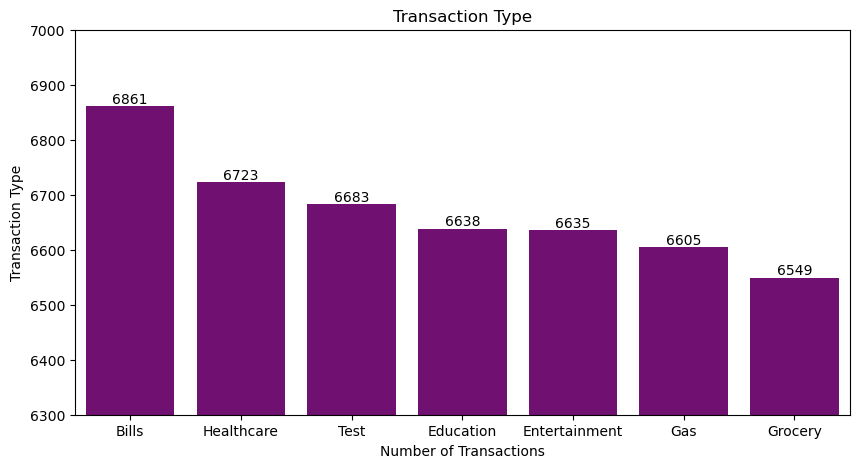

In [59]:
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.barplot(x='categories', y='frequency', data=types_df, color='purple')
plt.title('Transaction Type')
plt.xlabel('Number of Transactions')
plt.ylabel('Transaction Type')
plt.ylim(6300, 7000)
ax.bar_label(ax.containers[0])
plt.savefig('./images/transaction_types_amounts', dpi=500); 

In [60]:
states = pd_customers.groupby(['CUST_STATE'])['CUST_STATE'].count()
states

CUST_STATE
AL     5
AR     5
CA    45
CT    14
FL    64
GA    73
IA    21
IL    58
IN    13
KY    17
MA    33
MD    50
MI    44
MN    28
MS    24
MT     9
NC    37
NJ    53
NY    96
OH    44
PA    72
SC    30
TX    33
VA    39
WA    16
WI    29
Name: CUST_STATE, dtype: int64

In [61]:
state_names= pd_customers.CUST_STATE.value_counts()
state_count = state_names.reset_index()
state_count.columns = ['states', 'frequency']
state_count

,states,frequency
0,NY,96
1,GA,73
2,PA,72
3,FL,64
4,IL,58
5,NJ,53
6,MD,50
7,CA,45
8,OH,44
9,MI,44


In [62]:
#limit 8
top_8_states = state_count.nlargest(8, ['frequency'])
top_8_states

,states,frequency
0,NY,96
1,GA,73
2,PA,72
3,FL,64
4,IL,58
5,NJ,53
6,MD,50
7,CA,45


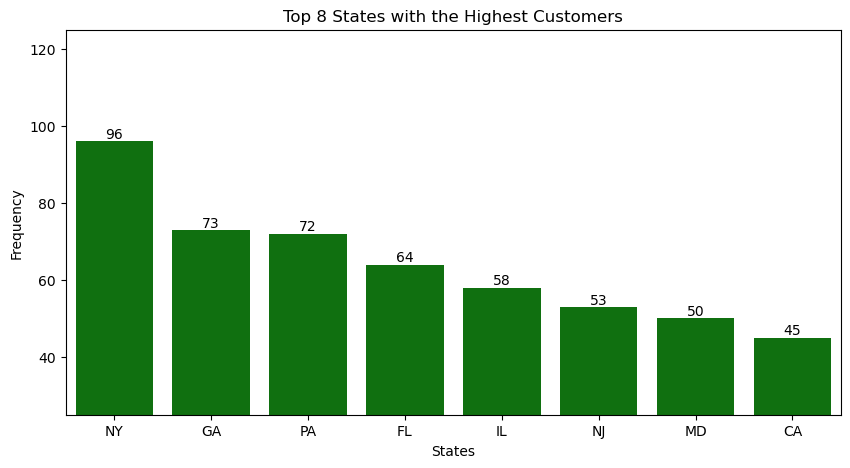

In [63]:
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.barplot(x='states', y='frequency', data=top_8_states, color='green')
#ax.set_title('Transaction Type')
#ax.set_xlabel('Number of Transactions')
#ax.set_ylabel('Transaction Type')
#ax.set_ylim(6300, 7000)
plt.title('Top 8 States with the Highest Customers')
plt.xlabel('States')
plt.ylabel('Frequency')
plt.ylim(25, 125)
ax.bar_label(ax.containers[0])
plt.savefig('./images/top_8_states_by_customer', dpi=500);

In [64]:
customer_transaction = pd_credit.groupby(['CUST_SSN'])['TRANSACTION_VALUE'].sum()
customer_transaction

CUST_SSN
123451007    2037.98
123451012    4025.69
123451037    2122.20
123451041    1085.14
123451068    2810.54
              ...   
123459940      96.27
123459965    2152.70
123459968     964.21
123459978    3091.78
123459988    4760.29
Name: TRANSACTION_VALUE, Length: 952, dtype: float64

In [65]:
individual_cust = customer_transaction.reset_index()
individual_cust.sort_values(by=['TRANSACTION_VALUE'], ascending=False, inplace=True)
individual_cust

,CUST_SSN,TRANSACTION_VALUE
14,123451125,5633.07
177,123452783,5548.14
248,123453486,5476.08
814,123458668,5314.97
599,123456678,5261.03
...,...,...
493,123455652,73.59
238,123453375,73.08
873,123459201,61.67
129,123452345,10.41


In [66]:
biggest_spender = individual_cust.sort_values(by=['TRANSACTION_VALUE'], ascending=False).head(1)
biggest_spender

,CUST_SSN,TRANSACTION_VALUE
14,123451125,5633.07


In [67]:
top_15_customers= individual_cust.nlargest(15, ['TRANSACTION_VALUE'])
top_15_customers

,CUST_SSN,TRANSACTION_VALUE
14,123451125,5633.07
177,123452783,5548.14
248,123453486,5476.08
814,123458668,5314.97
599,123456678,5261.03
99,123452026,5241.18
152,123452518,5223.96
414,123454933,5203.08
693,123457547,5149.75
102,123452085,5133.29


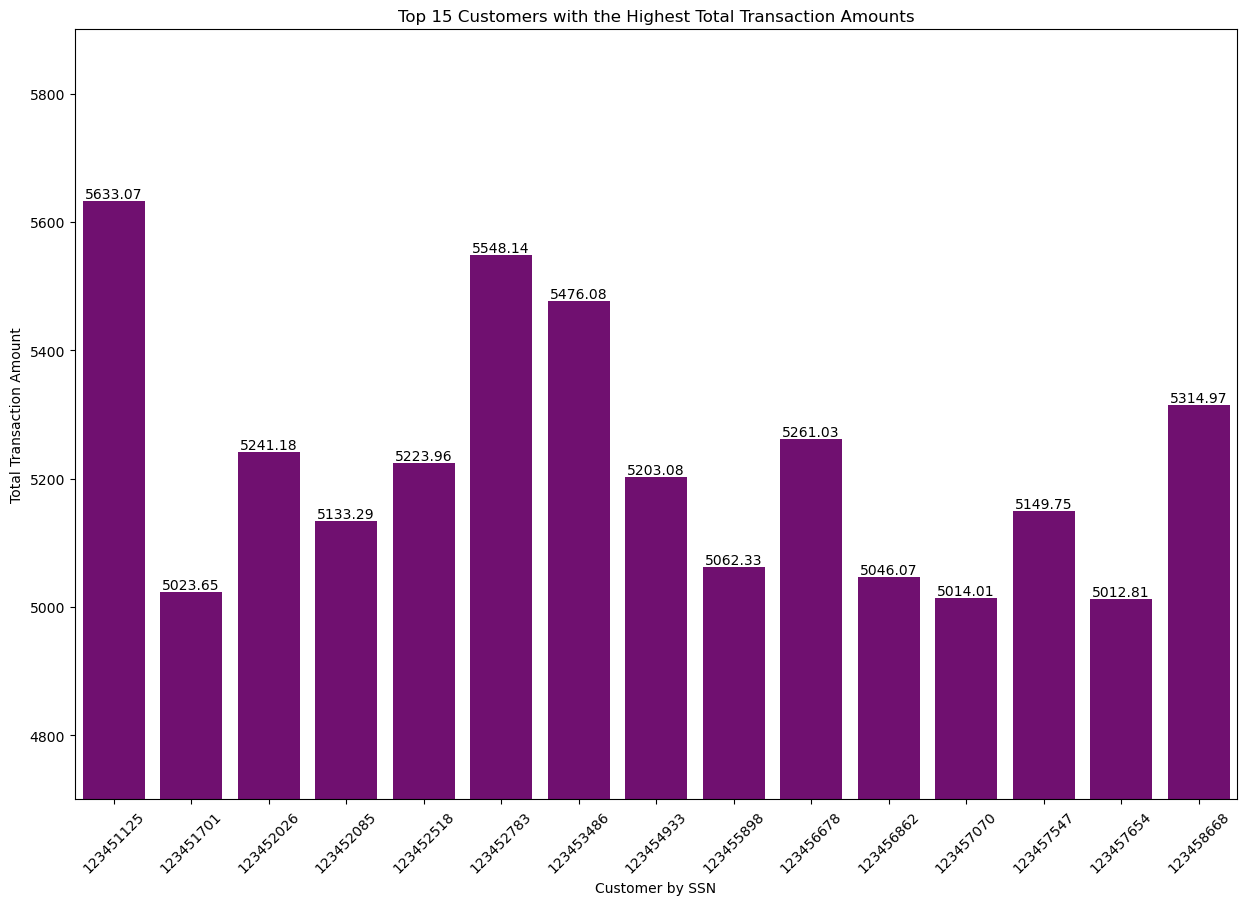

In [68]:

fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.barplot(x='CUST_SSN', y='TRANSACTION_VALUE', data=top_15_customers, color='purple')
#ax.set_title('Transaction Type')
#ax.set_xlabel('Number of Transactions')
#ax.set_ylabel('Transaction Type')
#ax.set_ylim(6300, 7000)
plt.title('Top 15 Customers with the Highest Total Transaction Amounts')
plt.xlabel('Customer by SSN')
plt.ylabel('Total Transaction Amount')
plt.ylim(4700, 5900)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.bar_label(ax.containers[0])
plt.savefig('./images/top15_customers_by_total_transaction_amounts', dpi=500);

In [69]:
pd_branch.to_csv('/Users/purple/Documents/Project/Data_Engineering/Python/Capstone1/data/pd_branch.csv', index=False)
pd_credit.to_csv('/Users/purple/Documents/Project/Data_Engineering/Python/Capstone1/data/pd_credit.csv', index=False)
pd_customers.to_csv('/Users/purple/Documents/Project/Data_Engineering/Python/Capstone1/data/pd_customers.csv', index=False)
pd_branch_and_credit.to_csv('/Users/purple/Documents/Project/Data_Engineering/Python/Capstone1/data/pd_branch_and_credit.csv', index=False)
pd_cust_and_credit.to_csv('/Users/purple/Documents/Project/Data_Engineering/Python/Capstone1/data/pd_cust_and_credit.csv', index=False)

In [70]:
## exporting pandas dataframes to use further


In [71]:
spark.stop()